In [3]:
from googleapiclient.discovery import build
import pandas as pd
import seaborn as sns

In [4]:
# api_key = 'YOUR youtube api key'

channel_ids = ['UCsXVk37bltHxD1rDPwtNM8Q', #kurzgesagt
               'UCHnyfMqiRRG1u-2MsSQLbXA', #veritasium
               'UCsooa4yRKGN_zEE8iknghZA', #ted ed
               'UCLXo7UDZvByw2ixzpQCufnA', #vox
               'UCNjPtOCvMrKY5eLwr_-7eUg', #alux.com
               'UCH4BNI0-FOK2dMXoFtViWHw', #be smart
              ]
youtube = build('youtube','v3',developerKey = api_key)

In [5]:
## Function to get channel statistics

In [6]:
def get_channel_stats(youtube,channel_ids):
    all_data = []
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=','.join(channel_ids)
    )
    response = request.execute()

    for i in range(len(response['items'])):
        data = dict(Channel_name = response['items'][i]['snippet']['title'],
                    Subscribers = response['items'][i]['statistics']['subscriberCount'],  
                    Views = response['items'][i]['statistics']['viewCount'],
                    Total_videos = response['items'][i]['statistics']['videoCount'],
                    Playlist_id = response['items'][i]['contentDetails']['relatedPlaylists']['uploads'])
        all_data.append(data)
                           
    return all_data

In [7]:
get_channel_stats(youtube,channel_ids)

[{'Channel_name': 'Be Smart',
  'Subscribers': '5230000',
  'Views': '646965356',
  'Total_videos': '454',
  'Playlist_id': 'UUH4BNI0-FOK2dMXoFtViWHw'},
 {'Channel_name': 'Veritasium',
  'Subscribers': '16000000',
  'Views': '2754397415',
  'Total_videos': '405',
  'Playlist_id': 'UUHnyfMqiRRG1u-2MsSQLbXA'},
 {'Channel_name': 'TED-Ed',
  'Subscribers': '20300000',
  'Views': '4013704263',
  'Total_videos': '2185',
  'Playlist_id': 'UUsooa4yRKGN_zEE8iknghZA'},
 {'Channel_name': 'Kurzgesagt – In a Nutshell',
  'Subscribers': '22800000',
  'Views': '2891301198',
  'Total_videos': '244',
  'Playlist_id': 'UUsXVk37bltHxD1rDPwtNM8Q'},
 {'Channel_name': 'Alux.com',
  'Subscribers': '4540000',
  'Views': '590976498',
  'Total_videos': '2657',
  'Playlist_id': 'UUNjPtOCvMrKY5eLwr_-7eUg'},
 {'Channel_name': 'Vox',
  'Subscribers': '12200000',
  'Views': '3561307856',
  'Total_videos': '1732',
  'Playlist_id': 'UULXo7UDZvByw2ixzpQCufnA'}]

In [8]:
channel_statistics = get_channel_stats(youtube,channel_ids)

In [9]:
channel_data = pd.DataFrame(channel_statistics)

In [14]:
channel_data 

,Channel_name,Subscribers,Views,Total_videos,Playlist_id
0,Alux.com,4540000,590976498,2657,UUNjPtOCvMrKY5eLwr_-7eUg
1,Kurzgesagt – In a Nutshell,22800000,2891301198,244,UUsXVk37bltHxD1rDPwtNM8Q
2,Veritasium,16000000,2754397415,405,UUHnyfMqiRRG1u-2MsSQLbXA
3,Vox,12200000,3561307856,1732,UULXo7UDZvByw2ixzpQCufnA
4,Be Smart,5230000,646965356,454,UUH4BNI0-FOK2dMXoFtViWHw
5,TED-Ed,20300000,4013704263,2185,UUsooa4yRKGN_zEE8iknghZA


In [19]:
channel_data['Subscribers'] = pd.to_numeric(channel_data['Subscribers'])
channel_data['Views'] = pd.to_numeric(channel_data['Views'])
channel_data['Total_videos'] = pd.to_numeric(channel_data['Total_videos'])
channel_data.dtypes

Channel_name    object
Subscribers      int64
Views            int64
Total_videos     int64
Playlist_id     object
dtype: object

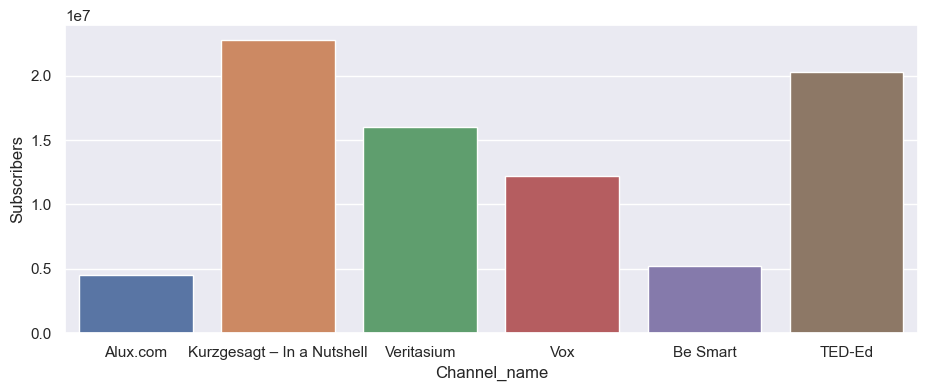

In [21]:
sns.set(rc = {'figure.figsize':(11,4)})
ax = sns.barplot(x='Channel_name',y='Subscribers',data=channel_data)

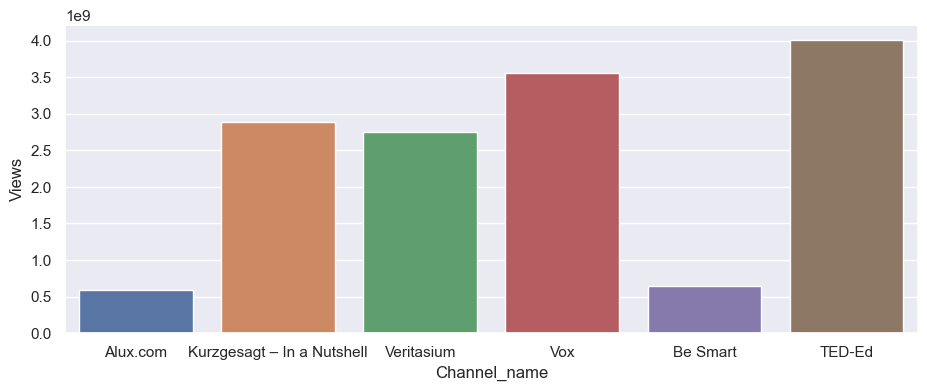

In [22]:
sns.set(rc = {'figure.figsize':(11,4)})
ax = sns.barplot(x='Channel_name',y='Views',data=channel_data)

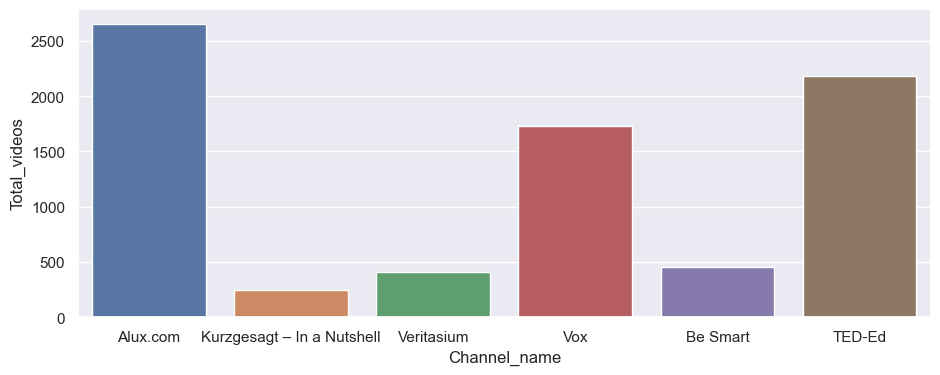

In [24]:
sns.set(rc = {'figure.figsize':(11,4)})
ax = sns.barplot(x='Channel_name',y='Total_videos',data=channel_data)

In [27]:
## Function to get video ids

In [29]:
playlist_id = channel_data.loc[channel_data['Channel_name']=='Kurzgesagt – In a Nutshell','Playlist_id'].iloc[0]

'UUsXVk37bltHxD1rDPwtNM8Q'

In [15]:
def get_video_ids(youtube, playlist_id):
    request = youtube.playlistItems().list(
        part = 'contentDetails',
        playlistId = playlist_id , 
        maxResults = 50)
    
    response = request.execute()
    video_ids = []
    for i in range(len(response['items'])):
        video_ids.append(response['items'][i]['contentDetails']['videoId'])

    next_page_token = response.get('nextPageToken')
    more_pages = True

    while more_pages:
        if next_page_token is None:
            more_pages = False
        else:
            request = youtube.playlistItems().list( 
            part = 'contentDetails',
            playlistId = playlist_id , 
            maxResults = 50,
            pageToken = next_page_token)
            response = request.execute()
        
            for i in range(len(response['items'])):
                video_ids.append(response['items'][i]['contentDetails']['videoId'])
            next_page_token = response.get('nextPageToken')
    
    return video_ids

In [16]:
video_ids = get_video_ids(youtube, playlist_id)

In [18]:
## Funtion to get videos details

In [19]:
def get_video_details(youtube,video_ids):
    all_videos_stats = []
    for i in range(0, len(video_ids),50):
        request = youtube.videos().list(
            part = 'snippet,statistics',
            id = ','.join(video_ids[i:i+50]))
        response=request.execute()
        for video in response['items']:
            video_stats = dict(Title = video['snippet']['title'],
                               Published_date = video['snippet']['publishedAt'],
                               Views = video['statistics']['viewCount'],
                               Likes = video['statistics']['likeCount'],
                               Comment_count = video['statistics']['commentCount']
                              )
            all_videos_stats.append(video_stats)  
    return all_videos_stats     

In [20]:
video_details = get_video_details(youtube,video_ids)

In [21]:
video_data = pd.DataFrame(video_details)
video_data

,Title,Published_date,Views,Likes,Comment_count
0,Fentanyl Explained #shorts,2024-08-22T14:00:28Z,564595,57163,1181
1,"Fever Feels Horrible, but is Actually Awesome!",2024-08-13T14:00:01Z,4497708,217367,8961
2,You're Not Ready,2024-08-08T14:00:13Z,779733,29124,1226
3,A.I. ‐ Humanity's Final Invention?,2024-08-06T14:00:09Z,4403466,191170,15183
4,The Sun is NOT Yellow! #shorts,2024-08-01T14:00:40Z,1201748,119849,1622
...,...,...,...,...,...
239,How The Stock Exchange Works (For Dummies),2013-11-28T17:03:32Z,8381947,131154,7095
240,The Gulf Stream Explained,2013-10-11T19:11:39Z,6056614,65430,2007
241,Fracking explained: opportunity or danger,2013-09-03T09:12:24Z,7324643,101847,8086
242,The Solar System -- our home in space,2013-08-22T13:24:56Z,6345698,84140,6145


In [22]:
video_data['Published_date'] = pd.to_datetime(video_data['Published_date']).dt.date
video_data['Views'] = pd.to_numeric(video_data['Views'])
video_data['Likes'] = pd.to_numeric(video_data['Likes'])
video_data['Comment_count'] = pd.to_numeric(video_data['Comment_count'])    
video_data

,Title,Published_date,Views,Likes,Comment_count
0,Fentanyl Explained #shorts,2024-08-22,564595,57163,1181
1,"Fever Feels Horrible, but is Actually Awesome!",2024-08-13,4497708,217367,8961
2,You're Not Ready,2024-08-08,779733,29124,1226
3,A.I. ‐ Humanity's Final Invention?,2024-08-06,4403466,191170,15183
4,The Sun is NOT Yellow! #shorts,2024-08-01,1201748,119849,1622
...,...,...,...,...,...
239,How The Stock Exchange Works (For Dummies),2013-11-28,8381947,131154,7095
240,The Gulf Stream Explained,2013-10-11,6056614,65430,2007
241,Fracking explained: opportunity or danger,2013-09-03,7324643,101847,8086
242,The Solar System -- our home in space,2013-08-22,6345698,84140,6145


In [23]:
top10_videos = video_data.sort_values(by = 'Views', ascending = False).head(10)
top10_videos

,Title,Published_date,Views,Likes,Comment_count
131,The Coronavirus Explained & What You Should Do,2020-03-19,88831352,1172287,72949
229,The Immune System Explained I – Bacteria Infec...,2014-07-01,53912618,542590,32283
164,What If You Detonated a Nuclear Bomb In The Ma...,2018-07-22,34406934,702609,29406
216,The Fermi Paradox — Where Are All The Aliens? ...,2015-05-06,33958620,729352,43089
122,The Largest Star in the Universe – Size Compar...,2020-09-22,33623938,775775,40388
167,The Deadliest Being on Planet Earth – The Bact...,2018-05-13,33559378,798398,52964
143,The Egg - A Short Story,2019-09-01,32289929,1936244,181773
151,What If We Detonated All Nuclear Bombs at Once?,2019-03-31,31578903,1094158,52851
182,Why Black Holes Could Delete The Universe – Th...,2017-08-24,29990712,527485,31895
197,Genetic Engineering Will Change Everything For...,2016-08-10,29760772,636487,71746


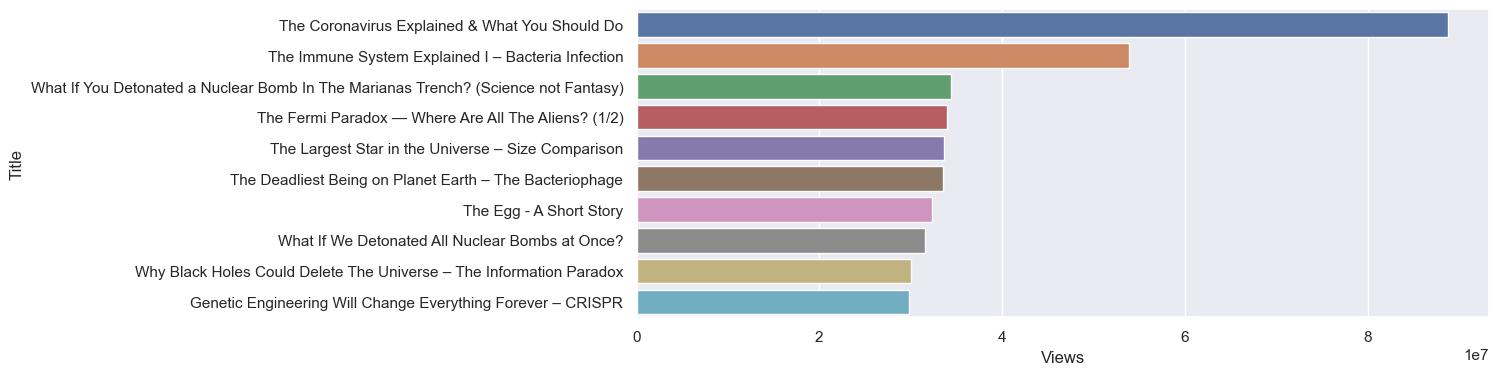

In [24]:
ax1 = sns.barplot(y='Title',x='Views',data = top10_videos)

In [25]:
video_data['Month'] = pd.to_datetime(video_data['Published_date']).dt.strftime('%b')
video_data

,Title,Published_date,Views,Likes,Comment_count,Month
0,Fentanyl Explained #shorts,2024-08-22,564595,57163,1181,Aug
1,"Fever Feels Horrible, but is Actually Awesome!",2024-08-13,4497708,217367,8961,Aug
2,You're Not Ready,2024-08-08,779733,29124,1226,Aug
3,A.I. ‐ Humanity's Final Invention?,2024-08-06,4403466,191170,15183,Aug
4,The Sun is NOT Yellow! #shorts,2024-08-01,1201748,119849,1622,Aug
...,...,...,...,...,...,...
239,How The Stock Exchange Works (For Dummies),2013-11-28,8381947,131154,7095,Nov
240,The Gulf Stream Explained,2013-10-11,6056614,65430,2007,Oct
241,Fracking explained: opportunity or danger,2013-09-03,7324643,101847,8086,Sep
242,The Solar System -- our home in space,2013-08-22,6345698,84140,6145,Aug


In [26]:
videos_per_month = video_data.groupby('Month',as_index=False).size()
videos_per_month

,Month,size
0,Apr,19
1,Aug,23
2,Dec,28
3,Feb,18
4,Jan,9
5,Jul,23
6,Jun,25
7,Mar,20
8,May,28
9,Nov,19


In [27]:
sort_by_order=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
videos_per_month.index = pd.CategoricalIndex(videos_per_month['Month'],categories=sort_by_order,ordered=True)
videos_per_month=videos_per_month.sort_index()

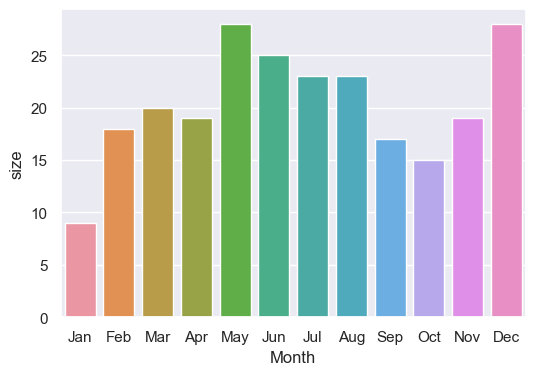

In [28]:
sns.set(rc = {'figure.figsize':(6,4)})
ax2 = sns.barplot(x='Month',y = 'size',data=videos_per_month)